# Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Parameters

In [2]:
DATA_PATH = "/content/drive/MyDrive/GAN/data"
LEARNING_RATE = 1e-5

# Imports

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torchsummary import summary

In [4]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
import itertools
import os
import random
import shutil
import time
from tqdm.notebook import tqdm

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Photo/Monet Dataset

In [7]:
class MonetDataset(Dataset):
  def __init__(self, monet_dir, photo_dir, transform):
    self.monet_dir = monet_dir
    self.photo_dir = photo_dir
    self.monet = [os.path.join(monet_dir, f) for f in os.listdir(monet_dir)]
    self.photo = [os.path.join(photo_dir, f) for f in os.listdir(photo_dir)]
    self.transform = transform

  def __len__(self):
    return min(len(self.monet), len(self.photo))

  def __getitem__(self, idx):
    monet = Image.open(self.monet[idx]).convert("RGB")
    photo = Image.open(random.choice(self.photo)).convert("RGB")

    monet = self.transform(monet)
    photo = self.transform(photo)

    return photo, monet

In [8]:
t = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
dataset = MonetDataset(
  f"{DATA_PATH}/monet_jpg/",
  f"{DATA_PATH}/photo_jpg/",
  transform = t
)

In [10]:
loader = DataLoader(dataset, batch_size=1, pin_memory=True)

In [11]:
def tensor_to_image(x):
    img = x[0].permute(1, 2, 0).cpu()  # C,H,W -> H,W,C
    img = (img + 1) / 2  # [-1,1] -> [0,1]
    return img

def show2(photo, monet):
  photo = tensor_to_image(photo)
  monet = tensor_to_image(monet)

  fig, axes = plt.subplots(1, 2, figsize=(10,5))
  axes[0].imshow(photo)
  axes[0].set_title("Photo")
  axes[0].axis('off')

  axes[1].imshow(monet)
  axes[1].set_title("Monet")
  axes[1].axis('off')

  plt.show()

def show3(photo, fake_monet, reconst_photo):
  photo = tensor_to_image(photo)
  fake_monet = tensor_to_image(fake_monet)
  reconst_photo = tensor_to_image(reconst_photo)

  fig, axes = plt.subplots(1, 3, figsize=(10,5))
  axes[0].imshow(photo)
  axes[0].set_title("Photo")
  axes[0].axis('off')

  axes[1].imshow(fake_monet)
  axes[1].set_title("Fake Monet")
  axes[1].axis('off')

  axes[2].imshow(reconst_photo)
  axes[2].set_title("Photo reconstruction")
  axes[2].axis('off')

  plt.show()

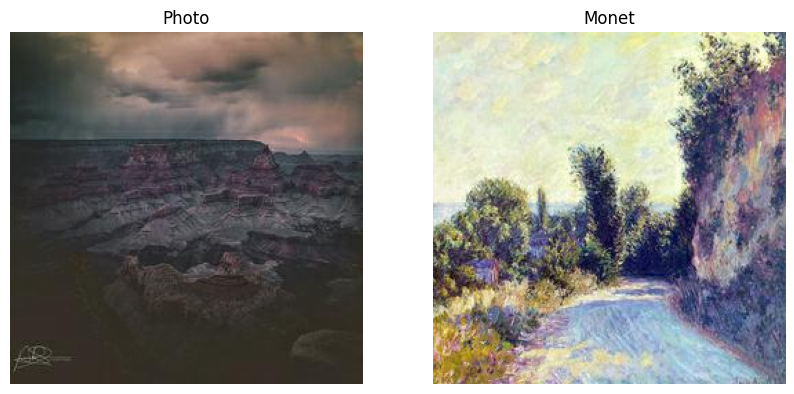

In [12]:
photo, monet = next(iter(loader))
show2(photo, monet)

# GAN Code

## Residual Neural Network Block

In [13]:
class ResNetBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(
                channels,
                channels,
                padding_mode="reflect",
                kernel_size=3,
                padding=1,
            ),
            nn.InstanceNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(
                channels,
                channels,
                padding_mode="reflect",
                kernel_size=3,
                padding=1,
            ),
            nn.InstanceNorm2d(channels),
        )

    def forward(self, X):
        # Residual connection
        return X + self.seq(X)


## Generator (ResNet)

In [14]:
class Generator(nn.Module):
    def __init__(self, n_res_blocks=9):
        super().__init__()

        encoder = [
            nn.Conv2d(
                3,
                64,
                kernel_size=7,
                padding=3,
                stride=1,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
        ]

        # ResNet blocks
        res_blocks = [ResNetBlock(256) for _ in range(n_res_blocks)]

        decoder = [
            nn.ConvTranspose2d(
                256, 128, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.InstanceNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(
                128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.InstanceNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 3, kernel_size=7, padding=3, padding_mode="reflect"),
            nn.Tanh(),
        ]

        self.seq = nn.Sequential(
            *encoder,
            *res_blocks,
            *decoder
        )

    def forward(self, x):
        return self.seq(x)


## Discriminator(PatchGAN)

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.seq = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
        )

    def forward(self, x):
        return self.seq(x)


## CycleGAN

In [16]:
class CycleGAN(nn.Module):
    def __init__(
        self, G_photo_monet, G_monet_photo, D_photo, D_monet, lambda_cycle=10.0
    ):
        super().__init__()
        self.G_photo_monet = G_photo_monet
        self.G_monet_photo = G_monet_photo
        self.D_photo = D_photo
        self.D_monet = D_monet

        self.lambda_cycle = lambda_cycle

        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()

        self.opt_G = optim.Adam(
            list(G_photo_monet.parameters()) + list(G_monet_photo.parameters()),
            lr=LEARNING_RATE,
            betas=(0.5, 0.999),
        )
        self.opt_D = optim.Adam(
            list(D_photo.parameters()) + list(D_monet.parameters()),
            lr=LEARNING_RATE,
            betas=(0.5, 0.999),
        )

    def train_step(self, real_photo, real_monet):
        # Switch to train mode
        self.G_photo_monet.train()
        self.G_monet_photo.train()
        self.D_photo.train()
        self.D_monet.train()

        # ======== Generators ========
        self.opt_G.zero_grad()

        fake_monet = self.G_photo_monet(real_photo)
        fake_photo = self.G_monet_photo(real_monet)

        # LSGAN
        out_D_monet = self.D_monet(fake_monet)
        loss_G_photo_monet = self.mse(
            out_D_monet, torch.ones_like(out_D_monet)
        )

        out_D_photo = self.D_photo(fake_photo)
        loss_G_monet_photo = self.mse(
            out_D_photo, torch.ones_like(out_D_photo)
        )

        # Cycle
        reconst_photo = self.G_monet_photo(fake_monet)
        reconst_monet = self.G_photo_monet(fake_photo)
        loss_cycle_photo = self.mae(reconst_photo, real_photo)
        loss_cycle_monet = self.mae(reconst_monet, real_monet)
        loss_cycle = loss_cycle_photo + loss_cycle_monet

        loss_G = (
            loss_G_photo_monet + loss_G_monet_photo +
            self.lambda_cycle * loss_cycle
        )

        loss_G.backward()
        self.opt_G.step()
        # ===========================

        # ======== Discriminators ========
        self.opt_D.zero_grad()

        out_D_real_photo = self.D_photo(real_photo)
        out_D_fake_photo = self.D_photo(fake_photo.detach())
        loss_D_photo = (
            self.mse(out_D_real_photo, torch.ones_like(out_D_real_photo)) +
            self.mse(out_D_fake_photo, torch.zeros_like(out_D_fake_photo))
        )

        out_D_real_monet = self.D_monet(real_monet)
        out_D_fake_monet = self.D_monet(fake_monet.detach())
        loss_D_monet = (
            self.mse(out_D_real_monet, torch.ones_like(out_D_real_monet)) +
            self.mse(out_D_fake_monet, torch.zeros_like(out_D_fake_monet))
        )

        loss_D = (loss_D_photo + loss_D_monet) * 0.5

        loss_D.backward()
        self.opt_D.step()
        # ================================

        return {
            "G": loss_G.item(),
            "D": loss_D.item(),
        }


In [17]:
def train_one_epoch(gan, loader):
    for photo, monet in tqdm(loader, desc="Training", unit="batch"):
        photo = photo.to(device, non_blocking=True)
        monet = monet.to(device, non_blocking=True)

        losses = gan.train_step(photo, monet)
    return losses


In [18]:
def sample(gan, loader):
  photo, monet = next(iter(loader))

  real_photo = photo.to(device)

  gan.G_photo_monet.eval()
  gan.G_monet_photo.eval()

  with torch.no_grad():
    fake_monet = gan.G_photo_monet(real_photo)
    reconst_photo = gan.G_monet_photo(fake_monet)

  show3(photo, fake_monet, reconst_photo)

# Training

In [19]:
gan = CycleGAN(
    G_photo_monet=Generator(n_res_blocks=6).to(device),
    G_monet_photo=Generator(n_res_blocks=6).to(device),
    D_photo=Discriminator().to(device),
    D_monet=Discriminator().to(device),
)

In [98]:
summary(gan.G_photo_monet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-2         [-1, 64, 256, 256]               0
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-5        [-1, 128, 128, 128]               0
              ReLU-6        [-1, 128, 128, 128]               0
            Conv2d-7          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-8          [-1, 256, 64, 64]               0
              ReLU-9          [-1, 256, 64, 64]               0
           Conv2d-10          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-11          [-1, 256, 64, 64]               0
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-14          [-1, 256,

In [99]:
summary(gan.D_photo, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-7          [-1, 256, 32, 32]               0
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-10          [-1, 512, 31, 31]               0
        LeakyReLU-11          [-1, 512, 31, 31]               0
           Conv2d-12            [-1, 1, 30, 30]           8,193
Total params: 2,764,737
Trainable params: 2,764,737
Non-trainable params: 0
---------------------------

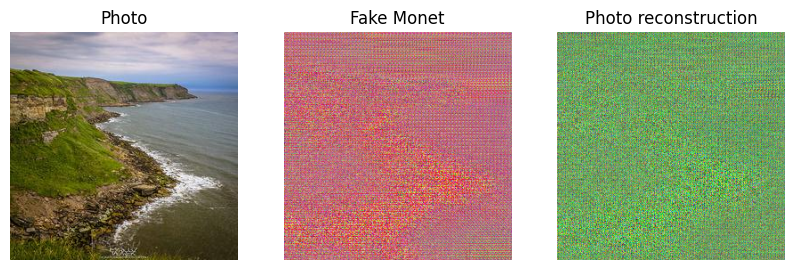

In [20]:
sample(gan, loader)

Training:   0%|          | 0/300 [00:00<?, ?batch/s]

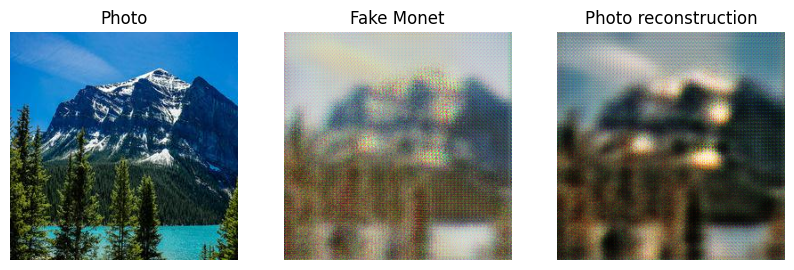

Training:   0%|          | 0/300 [00:00<?, ?batch/s]

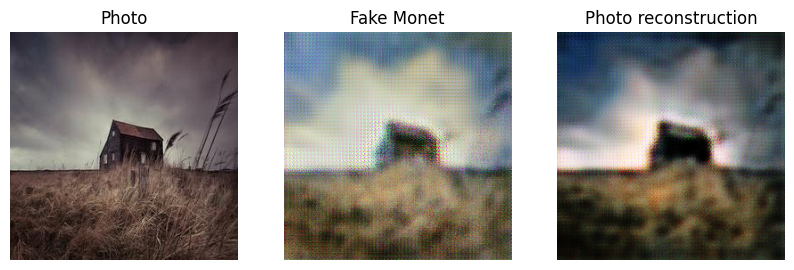

Training:   0%|          | 0/300 [00:00<?, ?batch/s]

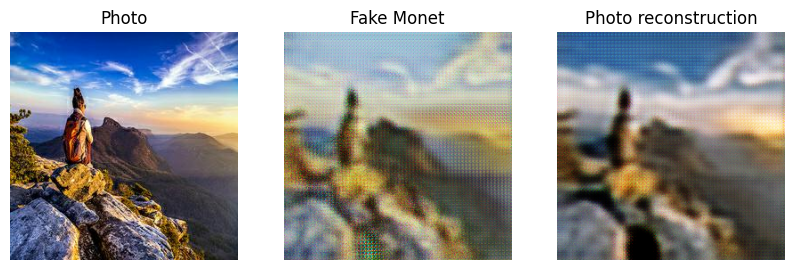

Training:   0%|          | 0/300 [00:00<?, ?batch/s]

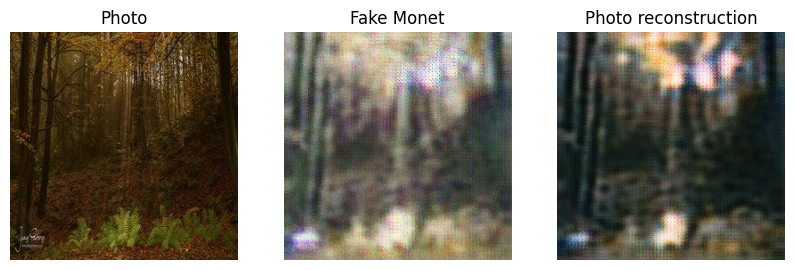

Training:   0%|          | 0/300 [00:00<?, ?batch/s]

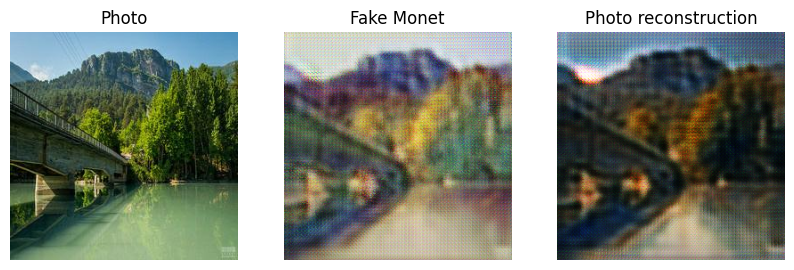

In [21]:
for _ in range(5):
    train_one_epoch(gan, loader)
    sample(gan, loader)